# Mini-projeto de ML - Dog Breed Recognition

# Parte 0 - Análise exploratória

Comecei o projeto criando um novo ambiente conda com Python 3.8.10 e um arquivo requirements.txt do pip, onde fui adicionando as dependências conforme necessário. Em seguida, escrevi um script para fazer download do dataset e extraí-lo: `download_dataset.py`, para facilitar a reprodução dos treinos e testes.

Em seguida, fiz uma análise exploratória dos dados. Vi a quantidade de arquivos em cada diretório do dataset. Pelo file explorer do meu sistema operacional, visualizei várias imagens para ter uma ideia do conteúdo. Percebi que havia algumas imagens bem escuras, que sob análise detalhada percebi serem completamente pretas. Criei um script para remover essas imagens da pasta train. Percebi também que havia imagens duplicadas, não só dentro de um diretório, como também entre diretórios. Algumas das duplicatas eram porque havia múltiplos cachorros na imagem, de raças diferentes; essas imagens mantive. Já as imagens duplicadas dentro de um mesmo diretório, removi. Criei um arquivo `clean_dataset.py` para juntar essa funcionalidade e a de remover imagens pretas.

Em seguida, examinei a quantidade de amostras por classe no train. A classe com menos amostras tem 145 amostras, e a com mais amostras, 252. Julguei que estão relativamente balanceadas, e portanto não usei nenhuma técnica para tratar class imbalance.

Continuando a análise exploratória, gerei um histograma de *aspect ratios* das imagens, que vão de aproximadamente 0.5 a 1.5. Por ser uma faixa de valores razoavelmente pequena, julguei não ser necessário fazer nada especial para tratar *aspect ratios* muito diferentes.

# Parte 1 - Treinar um modelo para classificar 100 raças de cachorros

Escolhi usar a biblioteca de deep learning [fastai](https://github.com/fastai/fastai), que usa o PyTorch, devido a algumas facilidades que ela proporciona, como bons defaults para fine-tuning de redes e facilidade de encontrar um learning rate perto do ótimo (método lr_find do objeto a ser treinado).

Para a Parte 1, treinei alguns classificadores para as 100 raças usando redes pré-treinadas no ImageNet. As imagens do ImageNet tem características parecidas com as do dataset de cachorros; por exemplo, o objeto de interesse geralmente está no centro da imagem. Julguei então que uma rede pré-treinada no ImageNet seria um bom ponto de partida. Treinei algumas redes diferentes, como Resnet50, alguns tamanhos de DenseNet, e por fim a rede 'resnext50_32x4d'. Essa foi a que obteve o melhor desempenho, com cerca de 93.6% de acurácia no validation set com 5 épocas de treinamento, com train/validation split de 0.8/0.2. Julguei ser um bom resultado, considerando que há 100 classes e muitas raças de cachorros são parecidas entre si. Caso fosse necessário aumentar a acurácia, eu tentaria os seguintes métodos: treinar por mais épocas; usar data augmentation; usar uma rede com maior resolução de entrada; usar test-time augmentation; usar *ensemble* de diferentes modelos de classificação; observar as imagens com maior loss visando encontrar problemas de labels errados ou de outros tipos no dataset de treinamento. Por fim, não treinei com todos os dados disponíveis, mas apenas com os 80% do train/val split; para um modelo de produção, talvez fosse interessante treinar com 100% dos dados.

O modelo treinado está disponível [aqui](https://drive.google.com/uc?id=1UyLNp68kYoZglzfyDOduEPzXcS6sJwR4). Consiste em um pickle do objeto `Learner` do fastai, que contém dentro de si o modelo PyTorch treinado com seus pesos, e também o código e parâmetros necessários para redimensionar a imagem, normalizar, e decodificar a classe de saída para uma string. Caso fosse necessári usar o modelo em ambiente de produção, seria recomendável exportá-lo para um formato como ONNX, e criar código comum para redimensionamento / normalização / decodificação.

Observação: Não consegui deixar o processo de treinamento do modelo determinístico. Portanto, os valores que aparecem nas células podem diferir um pouco daqueles no texto.

In [1]:
from fastai.vision.all import *
import torchvision.models as models

print("cuda.is_available: {}".format(torch.cuda.is_available()))

set_seed(1234)

cuda.is_available: True


## Load data for training and validation

In [2]:
def load_data(path):
    # for each image file, parent folder's name will be used as label
    dls = ImageDataLoaders.from_folder(
        path,
        valid_pct=0.2,
        item_tfms=Resize(224),
        bs=64,
    )
    return dls
    
path = "dogs/train/"

dls = load_data(path)

In [3]:
print(f"number of train samples: {dls.train.n}")
print(f"number of valid samples: {dls.valid.n}")

number of train samples: 13647
number of valid samples: 3411


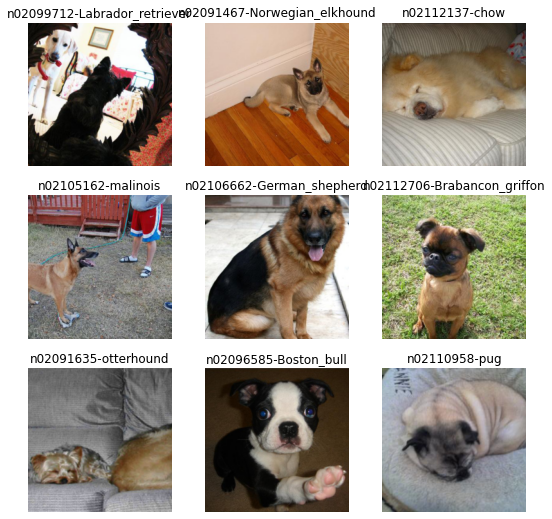

In [4]:
dls.show_batch()

## Train classifier for dog breeds

In [5]:
learn = cnn_learner(dls, models.resnext50_32x4d, cut=-1, pretrained=True, metrics=accuracy)

0.0004786300996784121


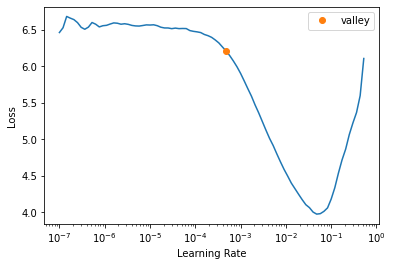

In [6]:
lr_min = learn.lr_find()
print(lr_min.valley)

In [7]:
learn.fit_one_cycle(
    5,
    lr_min.valley,
    cbs=[SaveModelCallback(monitor="accuracy")]
)

epoch,train_loss,valid_loss,accuracy,time
0,1.244345,0.325706,0.898563,01:51
1,0.510151,0.254985,0.922897,01:50
2,0.341416,0.243767,0.921724,01:51
3,0.245469,0.219677,0.933744,01:51
4,0.181094,0.212923,0.935796,01:51


Better model found at epoch 0 with accuracy value: 0.8985634446144104.
Better model found at epoch 1 with accuracy value: 0.9228965044021606.
Better model found at epoch 3 with accuracy value: 0.9337437748908997.
Better model found at epoch 4 with accuracy value: 0.9357959628105164.


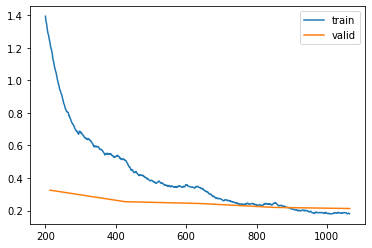

In [8]:
learn.recorder.plot_loss(skip_start=200)

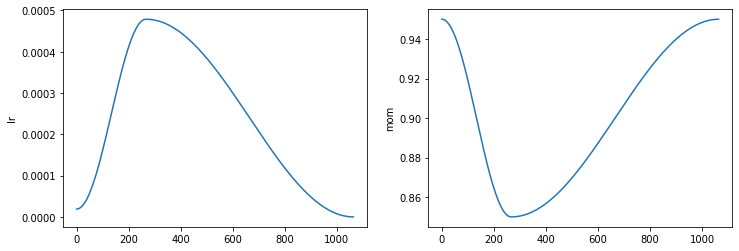

In [9]:
learn.recorder.plot_sched()

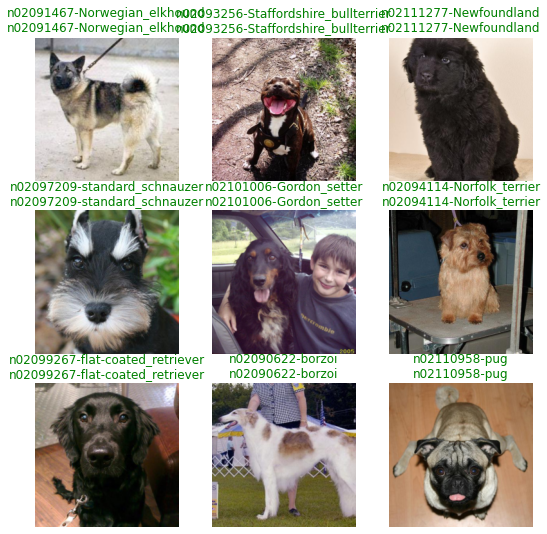

In [10]:
learn.show_results()

In [11]:
Path("models").mkdir(exist_ok=True)
learn.export(Path("models/exported_resnext50_32x4d.pickle").absolute())

## Use trained model to predict the class of some images

In [42]:
paths = dls.valid.items

In [43]:
def test(path):
    img = PILImage.create(path)
    pred, pred_ix, probs = learn.predict(img)
    print(f"Groundtruth class: {path.parent.name}")
    print(f"Predicted   class: {pred} with prob {probs[pred_ix]}")
    show_image(img)

Groundtruth class: n02106382-Bouvier_des_Flandres
Predicted   class: n02106382-Bouvier_des_Flandres with prob 0.9997794032096863


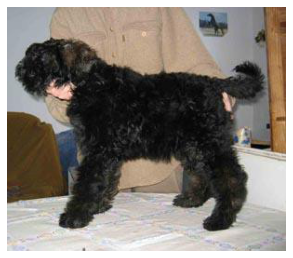

In [47]:
test(paths[100])

Groundtruth class: n02102480-Sussex_spaniel
Predicted   class: n02102480-Sussex_spaniel with prob 0.9942713975906372


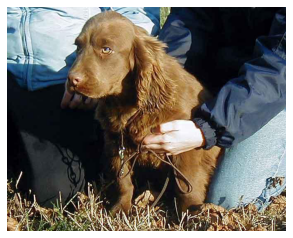

In [45]:
test(paths[200])

Groundtruth class: n02106166-Border_collie
Predicted   class: n02106166-Border_collie with prob 0.9671226143836975


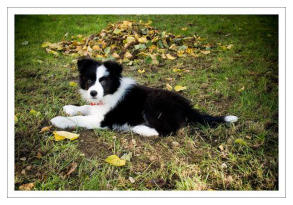

In [48]:
test(paths[300])

# Parte 2 - Classificação via busca de similaridade de embeddings com k-NN

Na Parte 2, identifiquei que seria interessante usar a rede treinada na Parte 1 para calcular um embedding (vetor descritor, ou vetor de features) de cada imagem, e usar esses embeddings para fazer o enroll de novas imagens e classificação das imagens de teste. A justificativa é que a rede da Parte 1 deve ter aprendido features que conseguem distinguir entre as 100 raças de cachorros, e portanto essas mesmas features podem ser usadas na Parte 2. Removi as últimas camadas da rede resnext50 treinada na Parte 1, logo depois de uma operação AdaptiveAvgPool2d, obtendo assim um descritor com 2048 dimensões para cada imagem. Julguei o número de dimensões um pouco grande, porém adequado.

Uma alternativa para a Parte 2 seria modelar como um problema de aprender a similaridade entre amostras. Poderia ser treinada uma nova rede, utilizando as amostras das 100 raças, mas usando triplet loss ou constrastive loss. A ideia dessas funções de loss é fazer a rede aprender uma métrica, dando uma distância pequena para pares de amostras "parecidas" (da mesma raça) e uma distância grande para pares de amostras diferentes (raças diferentes). Porém, optei por usar embedding com a rede da Parte 1, por já estar treinada e ser uma solução mais simples ("always start with the simplest thing that could possibly work".)

Minha primeira ideia para fazer a classificação dos descritores foi usar um SVM linear. Porém, seria necessário retreiná-lo para cada nova imagem cadastrada na base de busca. O treinamento de um SVM linear é um processo rápido, e possivelmente ficaria abaixo de 1 segundo, mas julguei que não estaria seguindo o espírito do projeto, que pede uma solução que possa ser treinada online, ou seja, que permita indexação incremental.

Mesmo assim, experimentei treinar um [SVM linear](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) com a biblioteca [scikit-learn](https://scikit-learn.org/stable/index.html), com todas as imagens da pasta enroll, e calculei a acurácia para a pasta teste, obtendo acima de 98% de acurácia. Para a Parte 3, tratei o problema de imagens de raças desconhecidas aplicando um limiar na saída de probabilidade do SVM linear. Para tanto, foi necessário treinar o SVM para que emitisse probabilidades na saída (o que não é uma funcionalidade "nativa" do SVM, e sim um processo de calibração de probabilidade feito via cross-validation). Os experimentos com SVM linear foram omitidos deste notebook.

Por fim, julgando que o aspecto de indexação incremental da Parte 2 é uma parte fundamental do problema, abandonei a solução com SVM linear e escolhi modelar como um problema de busca de similaridade de vetores, através da medição de distância entre vetores de embeddings, e o uso do algoritmo de k-nearest neighbors (k-NN) para determinar a classe vencedora. É um algoritmo simples que pode ser facilmente implementado do zero, mas visando uma solução que pudesse ser usada em escala, escolhi a biblioteca [faiss](https://github.com/facebookresearch/faiss) do Facebook, usada para busca de similaridade eficiente e clustering de vetores densos. O [faiss](https://github.com/facebookresearch/faiss) permite indexar vetores de forma incremental, como desejado. Além de busca exata de k-NN, implementa também algoritmos aproximados, que podem ser mais apropriados para uso em escala muito grande. Escolhi usar busca exata, por ser boa o suficiente para um problema desse tamanho; e escolhi usar distância cosseno ao invés de distância euclidiana, pois em um projeto anterior obtive bons resultados dessa forma.

Há uma escolha interessante a ser feita que é o valor de k, o número de vizinhos a serem considerados na busca. Valores pequenos de k podem resultar em um sistema um pouco ruidoso, pois a classe vencedora acaba dependendo de uma única amostra; em outras palavras, a fronteira de decisão fica complexa. Porém, valores grandes de k significam que o usuário terá que adicionar no mínimo floor(k/2)+1 amostras de cada classe para poder classificar novas imagens dessa classe. Por fim, escolhi usar k = 5, por ser o menor valor de k que retornou a acurácia máxima no conjunto de teste.

A acurácia de teste foi medida da seguinte forma. Primeiro, todas as imagens da pasta `enroll` foram indexadas (adicionadas ao sistema de busca). Em seguida, foi obtida a classe de predição para cada imagem da pasta `test` e comparada com a classe verdadeira. A acurácia resultante para k = 5 foi de 0.985.

In [26]:
from fastai.vision.all import *

from utils import get_embedding, label_func

from importlib import reload
import search
reload(search)
from search import FaissImageSearch, search_from_path, search_accuracy, plot_results, calculate_rejection_accuracy

import matplotlib.pyplot as plt
plt.ion()

## Create image search object

In [18]:
learn = load_learner("models/exported_resnext50_32x4d.pickle")
searcher = FaissImageSearch(learn)

## Enroll some dog images

In [19]:
enroll_paths = get_image_files("dogs/recognition/enroll/")
enroll_class_names = [label_func(p) for p in enroll_paths]
enroll_imgs = [PILImage.create(p) for p in enroll_paths]

In [20]:
searcher.enroll_many(enroll_imgs, enroll_class_names)
searcher.dump("models")

## Calculate test accuracy

In [21]:
test_paths = get_image_files("dogs/recognition/test/")
test_class_names = [label_func(p) for p in test_paths]
test_imgs = [PILImage.create(p) for p in test_paths]

In [22]:
test_embeddings = get_embedding(searcher.learn, searcher.embedder, test_imgs)
Path("cache").mkdir(exist_ok=True)
pickle.dump(test_embeddings, open("cache/test_embeddings.pickle", "wb"))
# test_embeddings = pickle.load(open("cache/test_embeddings.pickle", "rb"))

k: 1  test_acc: 0.9728
k: 3  test_acc: 0.9825
k: 5  test_acc: 0.9845
k: 7  test_acc: 0.9854
k: 9  test_acc: 0.9854


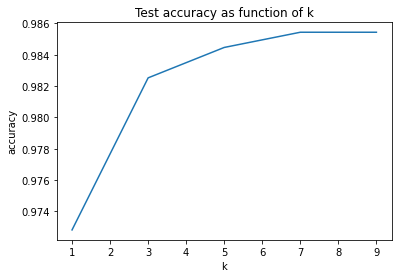

In [23]:
# calculate test accuracy for some values of hyperparameter k
# k is the number of nearest neighbors used when searching
ks = [1,3,5,7,9]
test_accs = []
for k in ks:
    acc, dist_all, dist_correct, dist_incorrect, dist_empty = search_accuracy(
        searcher, test_embeddings, test_class_names, k=k, threshold=0.0)
    test_accs.append(acc)
    print(f"k: {k}  test_acc: {acc:.04f}")
plt.plot(ks, test_accs)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Test accuracy as function of k")
plt.show()

## Plot distance histograms

dist_all.shape: (1030,)
dist_correct.shape: (1014,)
dist_incorrect.shape: (15,)
dist_empty.shape: (1,)


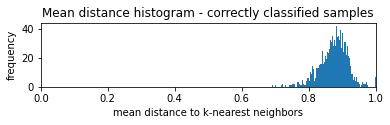

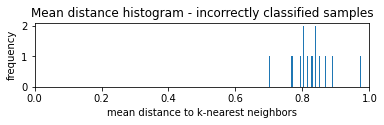

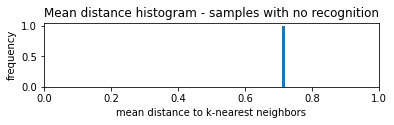

In [27]:
plot_results(searcher, test_embeddings, test_class_names)

# Parte 3 - Tratar raças previamente não vistas

A minha maior dúvida em todo o Teste Prático foi como detectar anomalias (amostras de classe desconhecida) com o modelo de k-NN. Acabei utilizando duas formas em conjunto. A primeira consiste em, no processo de busca, indicar que não foi possível classificar a imagem, caso não haja maioria nas k amostras mais próximas. A segunda forma foi estabelecer um limiar de distância para que cada vizinho seja considerado próximo o suficiente; o limiar foi determinado empiricamente. Uma desvantagem de usar detecção de anomalia é que inevitavelmente aumenta-se a chance de rejeitar classificações corretas de amostras com classe conhecida. De fato, observei que a acurácia de testes caiu ao implementar as duas formas de rejeição: para k = 5 e threshold = 0.78, a acurácia de teste caiu de 0.985 para 0.952. A escolha de um limiar que represente um bom tradeoff entre recall e precision é uma parte importante de projetos como esse.

Para medir quão bem o método de rejeição funciona, criei um dataset de imagens com raça desconhecida formado pelas amostras de validação da Parte 1 (20% das imagens da pasta `train`). Em seguida, medi a "acurácia de rejeição": a classificação de uma imagem desse dataset é considerada correta se retornar "unknown", caso contrário é considerada incorreta. Para k = 5 e threshold = 0.78 (limiar de distância), a acurácia de rejeição foi de 0.82. Isso significa que a probabilidade de uma imagem de raça desconhecida ser coretamente classificada como "unknown" é de 82%.

## Create dataset of unknown breeds (valid set of Part 1)

In [28]:
def load_data(path):
    # for each image file, parent folder's name will be used as label
    dls = ImageDataLoaders.from_folder(
        path,
        valid_pct=0.2,
        item_tfms=Resize(224),
        bs=64,
    )
    return dls

set_seed(1234)
path = "dogs/train/"
dls = load_data(path)

In [29]:
unknown_paths = dls.valid.items
unknown_class_names = [label_func(p) for p in unknown_paths]
unknown_imgs = [PILImage.create(p) for p in unknown_paths]
unknown_embeddings = get_embedding(searcher.learn, searcher.embedder, unknown_imgs)
pickle.dump(unknown_embeddings, open("cache/unknown_embeddings.pickle", "wb"))
# unknown_embeddings = pickle.load(open("cache/unknown_embeddings.pickle", "rb"))

## Calculate rejection accuracy

k: 1  rejection_acc: 0.6854
k: 3  rejection_acc: 0.7825
k: 5  rejection_acc: 0.8197
k: 7  rejection_acc: 0.8385
k: 9  rejection_acc: 0.8528


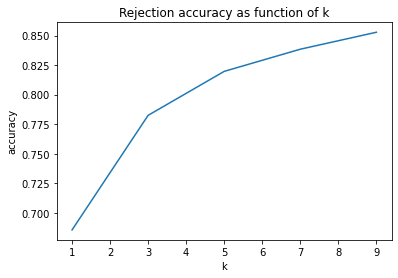

In [30]:
ks = [1,3,5,7,9]
rejection_accs = []
for k in ks:
    acc = calculate_rejection_accuracy(searcher, unknown_embeddings, k=k, threshold=0.78)
    rejection_accs.append(acc)
    print(f"k: {k}  rejection_acc: {acc:.04f}")
plt.plot(ks, rejection_accs)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Rejection accuracy as function of k")
plt.show()

## Plot test and rejection accuracy

In [38]:
k = 5
thresholds = np.linspace(0.75, 0.85, 11)
rejection_accs = []
test_accs = []
for threshold in thresholds:
    rejection_acc = calculate_rejection_accuracy(searcher, unknown_embeddings, k=k, threshold=threshold)
    test_acc, _, _, _, _ = search_accuracy(
        searcher, test_embeddings, test_class_names, k=k, threshold=threshold)
    rejection_accs.append(rejection_acc)
    test_accs.append(test_acc)
    print(f"threshold: {threshold}  test_acc: {test_acc:.04f}  rejection_acc: {rejection_acc:0.04f}")

threshold: 0.75  test_acc: 0.9650  rejection_acc: 0.6652
threshold: 0.76  test_acc: 0.9631  rejection_acc: 0.7232
threshold: 0.77  test_acc: 0.9573  rejection_acc: 0.7757
threshold: 0.78  test_acc: 0.9466  rejection_acc: 0.8197
threshold: 0.79  test_acc: 0.9320  rejection_acc: 0.8543
threshold: 0.8  test_acc: 0.9019  rejection_acc: 0.8854
threshold: 0.8099999999999999  test_acc: 0.8738  rejection_acc: 0.9132
threshold: 0.82  test_acc: 0.8282  rejection_acc: 0.9255
threshold: 0.83  test_acc: 0.7786  rejection_acc: 0.9446
threshold: 0.84  test_acc: 0.7155  rejection_acc: 0.9619
threshold: 0.85  test_acc: 0.6243  rejection_acc: 0.9710


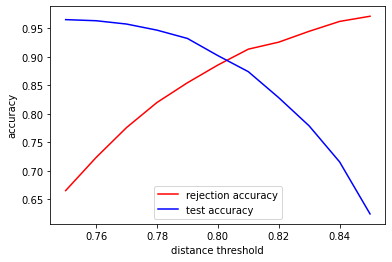

In [40]:
plt.plot(thresholds, rejection_accs, 'r', label='rejection accuracy')
plt.plot(thresholds, test_accs, 'b', label='test accuracy')
plt.xlabel("distance threshold")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Repositório e web apps de demonstração

Todo o código escrito para o Teste Prático está disponível em https://github.com/carnieri/dogbreed .

Escolhi o web framework [streamlit](https://streamlit.io/) para demonstrar o funcionamento da Parte 1 (`webapp_part1.py`) e Parte 2 + Parte 3 (`webapp_part2.py`).

Para rodar o servidor web da Parte 1 na linha de comando:

`$ streamlit run webapp_part1.py`

ou simplesmente: `$ ./run_webapp_part1.sh`

Para rodar o servidor web da Parte 2 + Parte 3:

`$ streamlit run webapp_part2.py`

ou simplesmente: `$ ./run_webapp_part2.sh`